In [218]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [219]:
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload

import bemcs


In [220]:
def plot_line_values(x, displacements, stresses, suptitle_string):
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 3, 2)
    plt.plot(x, displacements[0, :])
    plt.grid()
    plt.title("x displacement")

    plt.subplot(2, 3, 3)
    plt.plot(x, displacements[1, :])
    plt.grid()
    plt.title("y displacement")

    plt.subplot(2, 3, 4)
    plt.plot(x, np.log10(np.abs(stresses[0, :])))
    plt.grid()
    plt.title("xx stress")

    plt.subplot(2, 3, 5)
    plt.plot(x, np.log10(np.abs(stresses[1, :])))
    plt.grid()
    plt.title("yy stress")

    plt.subplot(2, 3, 6)
    plt.plot(x, np.log10(np.abs(stresses[2, :])))
    plt.grid()
    plt.title("xy stress")

    plt.suptitle(suptitle_string)


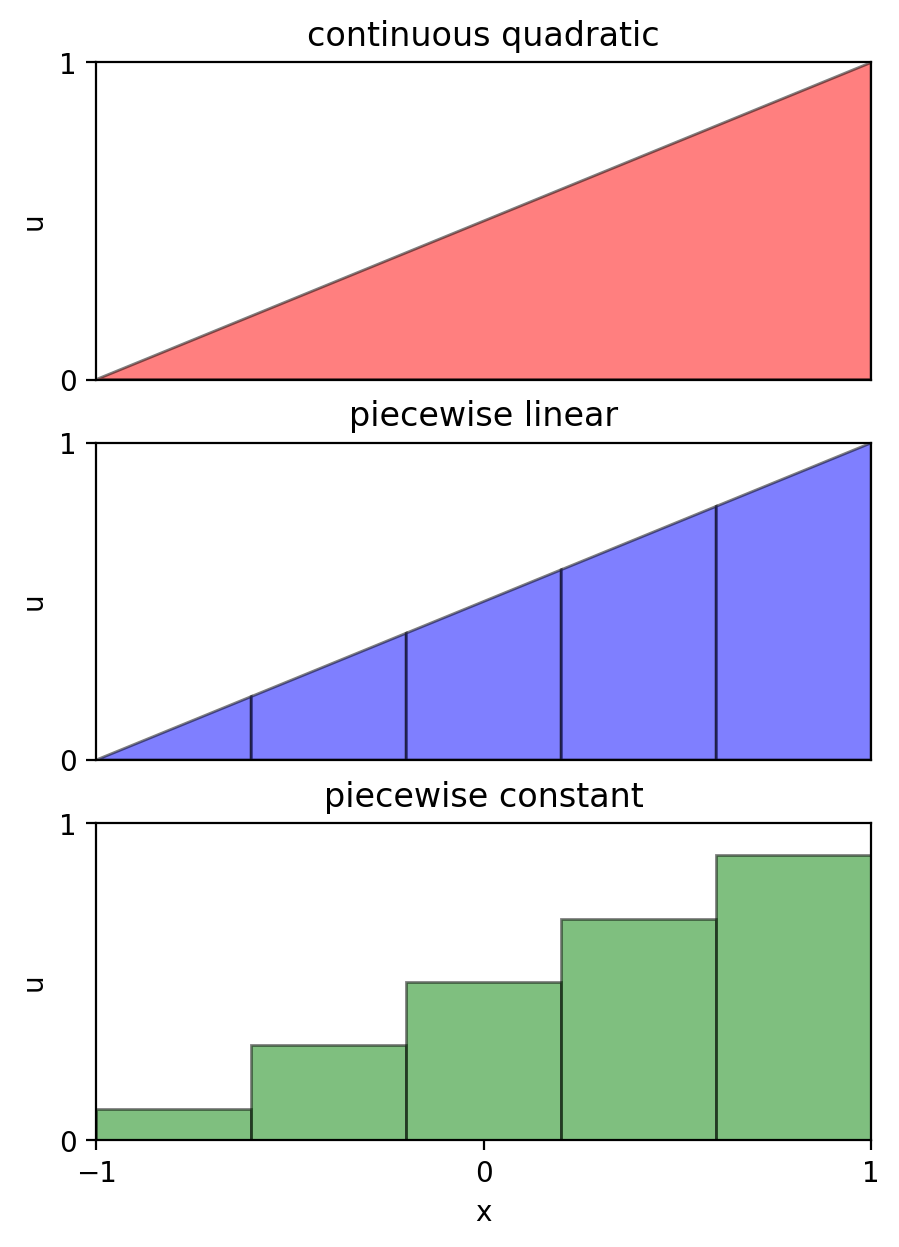

In [221]:
n_pts_high_resolution = 1000
n_pts_low_resolution = 6
n_elements = n_pts_low_resolution - 1
x_high_resolution = np.linspace(-1, 1, n_pts_high_resolution)
x_low_resolution = np.linspace(-1, 1, n_pts_low_resolution)

# Define a quadratic
y_true_high_resolution = 0.5 * x_high_resolution + 0.5
y_true_low_resolution = 0.5 * x_low_resolution + 0.5

# Define a piecweise linear approximation to quadratic
linear_x1 = np.zeros(n_elements)
linear_x2 = np.zeros(n_elements)
linear_y1 = np.zeros(n_elements)
linear_y2 = np.zeros(n_elements)
for i in range(n_elements):
    linear_x1[i] = x_low_resolution[i]
    linear_x2[i] = x_low_resolution[i + 1]
    linear_y1[i] = y_true_low_resolution[i]
    linear_y2[i] = y_true_low_resolution[i + 1]

# Define a piecewise constant apprximation to quadratic
constant_x1 = np.zeros(n_elements)
constant_x2 = np.zeros(n_elements)
constant_y1 = np.zeros(n_elements)
constant_y2 = np.zeros(n_elements)
for i in range(n_elements):
    constant_x1[i] = x_low_resolution[i]
    constant_x2[i] = x_low_resolution[i + 1]
    constant_y1[i] = 0.5 * (y_true_low_resolution[i] + y_true_low_resolution[i + 1])
    constant_y2[i] = 0.5 * (y_true_low_resolution[i] + y_true_low_resolution[i + 1])

# Plot nearly continuous vs. piecewise linear and piecwise constant
plt.figure(figsize=(5, 7))

# High-resolution quadratic
plt.subplot(3, 1, 1)
plt.fill(
    np.append(x_high_resolution, [x_high_resolution[-1], x_high_resolution[0]]),
    np.append(y_true_high_resolution, [0, 0]),
    "-r",
    alpha=0.5,
    edgecolor="k",
    label="quadratic",
)
plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([0, 1])
plt.ylabel("u")
plt.title("continuous quadratic")

# Linear slip elements
plt.subplot(3, 1, 2)
for i in range(n_elements):
    if i == 0:
        plt.fill(
            [linear_x1[i], linear_x2[i], linear_x2[i], linear_x1[i]],
            [linear_y1[i], linear_y2[i], 0, 0],
            "b",
            alpha=0.5,
            edgecolor="k",
            label="piecewise linear",
        )
    else:
        plt.fill(
            [linear_x1[i], linear_x2[i], linear_x2[i], linear_x1[i]],
            [linear_y1[i], linear_y2[i], 0, 0],
            "b",
            alpha=0.5,
            edgecolor="k",
        )

plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xticks([])
plt.yticks([0, 1])
plt.ylabel("u")
plt.title("piecewise linear")

# Constant slip elements
plt.subplot(3, 1, 3)
for i in range(n_elements):
    if i == 0:
        plt.fill(
            [constant_x1[i], constant_x2[i], constant_x2[i], constant_x1[i]],
            [constant_y1[i], constant_y2[i], 0, 0],
            "g",
            alpha=0.5,
            edgecolor="k",
            label="piecewise constant",
        )
    else:
        plt.fill(
            [constant_x1[i], constant_x2[i], constant_x2[i], constant_x1[i]],
            [constant_y1[i], constant_y2[i], 0, 0],
            "g",
            alpha=0.5,
            edgecolor="k",
        )
plt.xlim([-1, 1])
plt.ylim([0, 1])
plt.xticks([-1, 0, 1])
plt.yticks([0, 1])
plt.xlabel("x")
plt.ylabel("u")
plt.title("piecewise constant")
plt.show()


# Define geometry of single element model

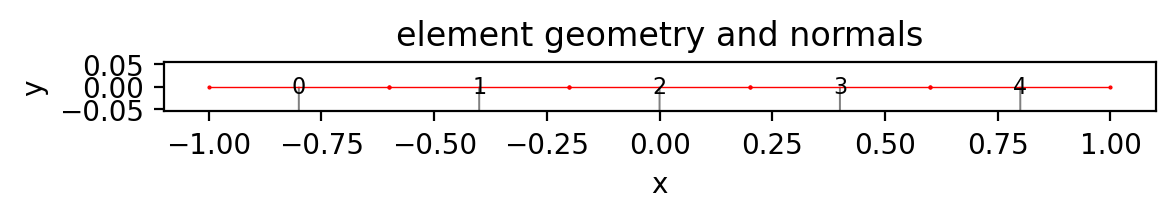

In [222]:
# List of elements for forward model
mu = np.array([3e10])
nu = np.array([0.25])
elements = []
element = {}
L = 1
x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, n_elements)

for i in range(0, x1.size):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())
elements = bemcs.standardize_elements(elements)
bemcs.plot_element_geometry(elements)


# Observation coordinates

In [223]:
n_pts = 1001
width = 1.1
x_obs = np.linspace(-width, width, n_pts)
y_obs = 1e-6 * np.ones_like(x_obs)


# Approximation with constant slip elements

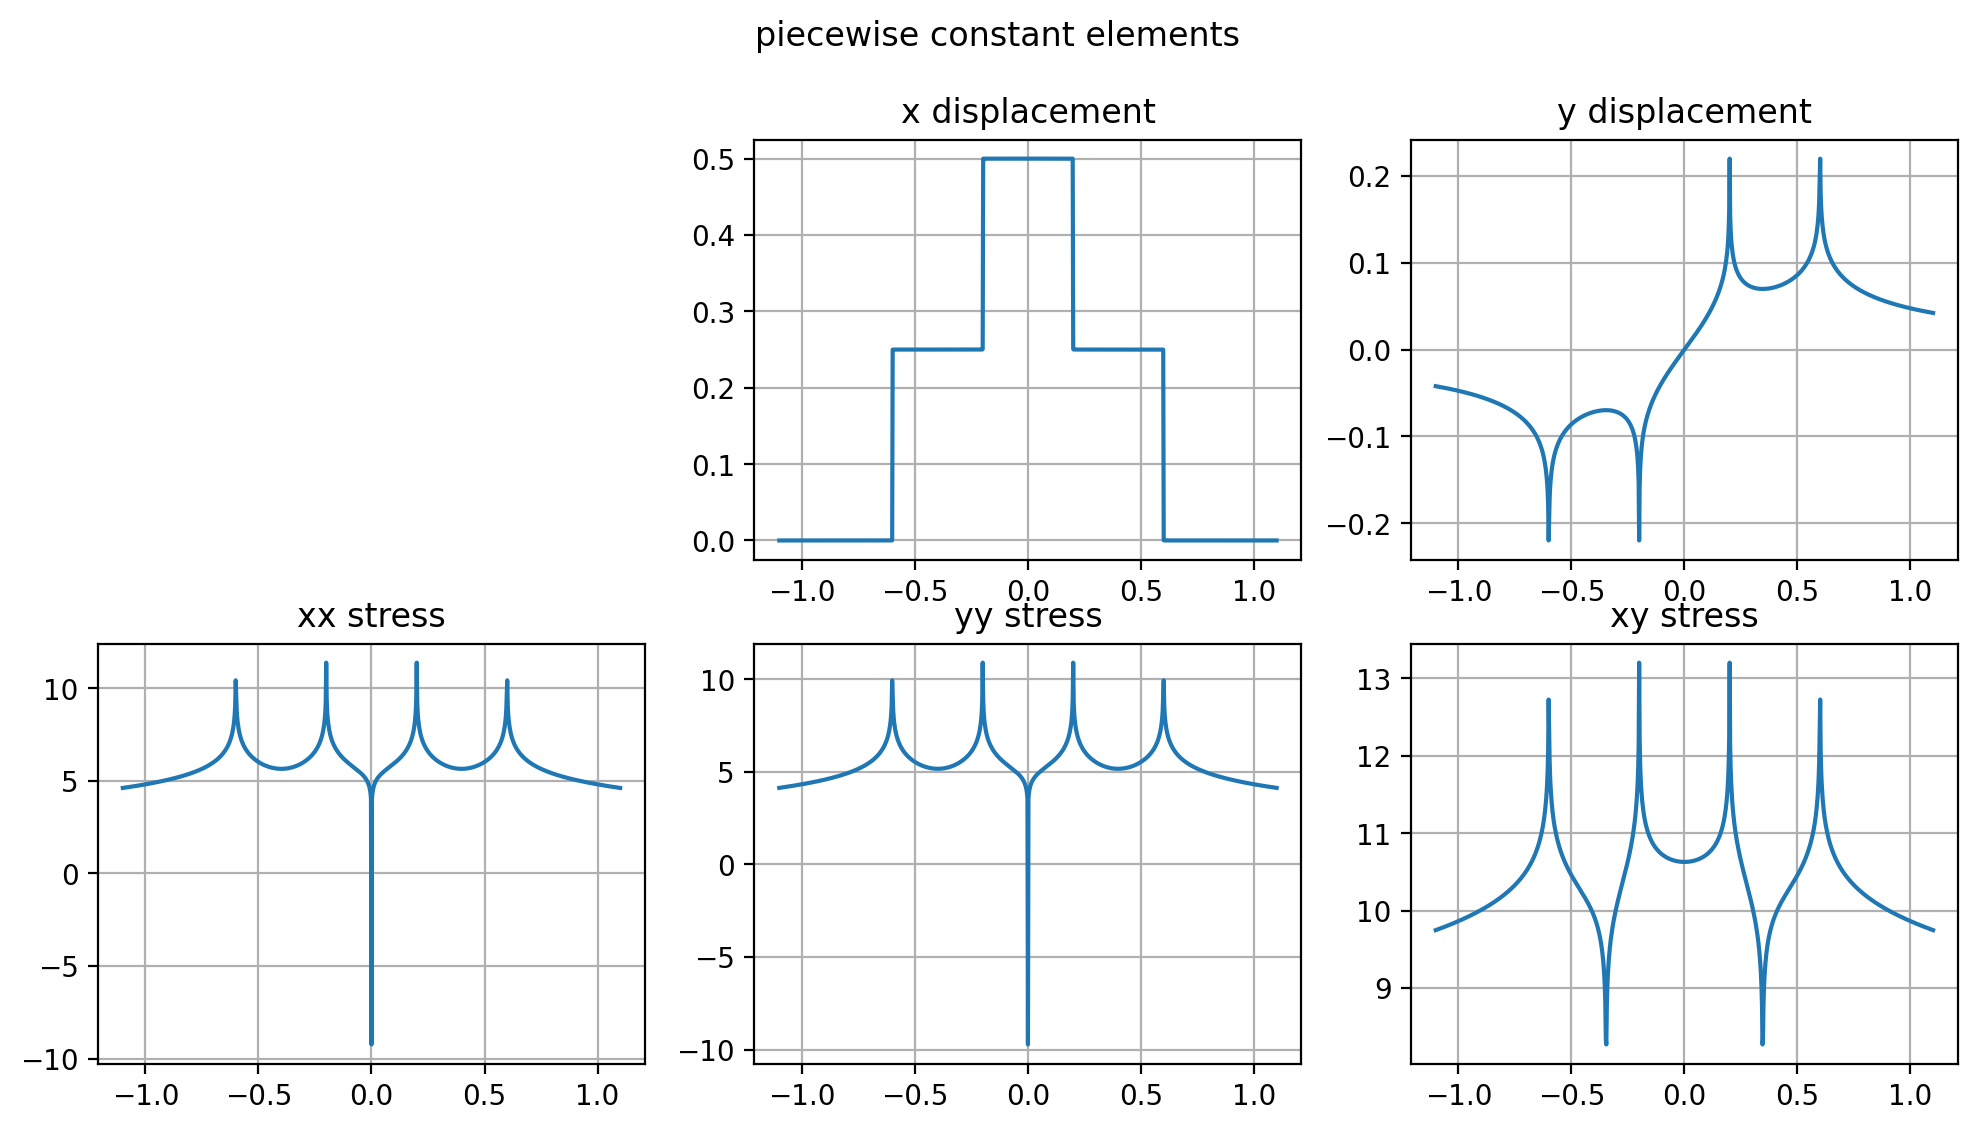

In [224]:
# strike_slip_constant = np.copy(constant_y1)
strike_slip_constant = np.array((0.,0.5,1.,0.5,0.))
tensile_slip_constant = 0

displacement_constant_total = np.zeros((2, len(x_obs)))
stress_constant_total = np.zeros((3, len(x_obs)))

for i in range(len(elements)):
    (
        displacement_constant,
        stress_constant,
    ) = bemcs.displacements_stresses_constant_no_rotation(
        x_obs,
        y_obs,
        elements[i]["half_length"],
        mu,
        nu,
        strike_slip_constant[i],
        tensile_slip_constant,
        elements[i]["x_center"],
        elements[i]["y_center"],
    )
    displacement_constant_total += displacement_constant
    stress_constant_total += stress_constant

    plt.show()

plot_line_values(
    x_obs,
    displacement_constant_total,
    stress_constant_total,
    "piecewise constant elements",
)


In [225]:
def LOCAL_get_quadratic_coefficients_for_linear_slip(
    a, node_coordinates, end_displacement_1, end_displacement_2
):
    center_displacment = (end_displacement_1 + end_displacement_2) / 2.0
    physical_displacements = np.array(
        [end_displacement_1, center_displacment, end_displacement_2]
    )
    print(f"LOCAL - {physical_displacements=}")
    quadratic_coefficients = LOCAL_phicoef(node_coordinates, physical_displacements, a)
    print(f"LOCAL - {quadratic_coefficients=}")
    return quadratic_coefficients


def LOCAL_phicoef(x, y, a):
    mat = np.zeros((len(x), 3))
    mat[:, 0] = (x / a) * (9 * (x / a) / 8 - 3 / 4)
    mat[:, 1] = (1 - 3 * (x / a) / 2) * (1 + 3 * (x / a) / 2)
    mat[:, 2] = (x / a) * (9 * (x / a) / 8 + 3 / 4)
    return np.linalg.inv(mat) @ y


# Approximation with linear slip elements

i=0
node_coordinates=array([-0.2,  0. ,  0.2])
end_displacement_1=0.000, end_displacement_2=0.500
LOCAL - physical_displacements=array([0.  , 0.25, 0.5 ])
LOCAL - quadratic_coefficients=array([0.08333333, 0.25      , 0.41666667])
strike_slip_linear=array([0.08333333, 0.25      , 0.41666667])
i=1
node_coordinates=array([-0.2,  0. ,  0.2])
end_displacement_1=0.500, end_displacement_2=1.000
LOCAL - physical_displacements=array([0.5 , 0.75, 1.  ])
LOCAL - quadratic_coefficients=array([0.58333333, 0.75      , 0.91666667])
strike_slip_linear=array([0.58333333, 0.75      , 0.91666667])
i=2
node_coordinates=array([-0.2,  0. ,  0.2])
end_displacement_1=1.000, end_displacement_2=1.000
LOCAL - physical_displacements=array([1., 1., 1.])
LOCAL - quadratic_coefficients=array([1., 1., 1.])
strike_slip_linear=array([1., 1., 1.])
i=3
node_coordinates=array([-0.2,  0. ,  0.2])
end_displacement_1=1.000, end_displacement_2=0.500
LOCAL - physical_displacements=array([1.  , 0.75, 0.5 ])
LOCAL - quadratic_co

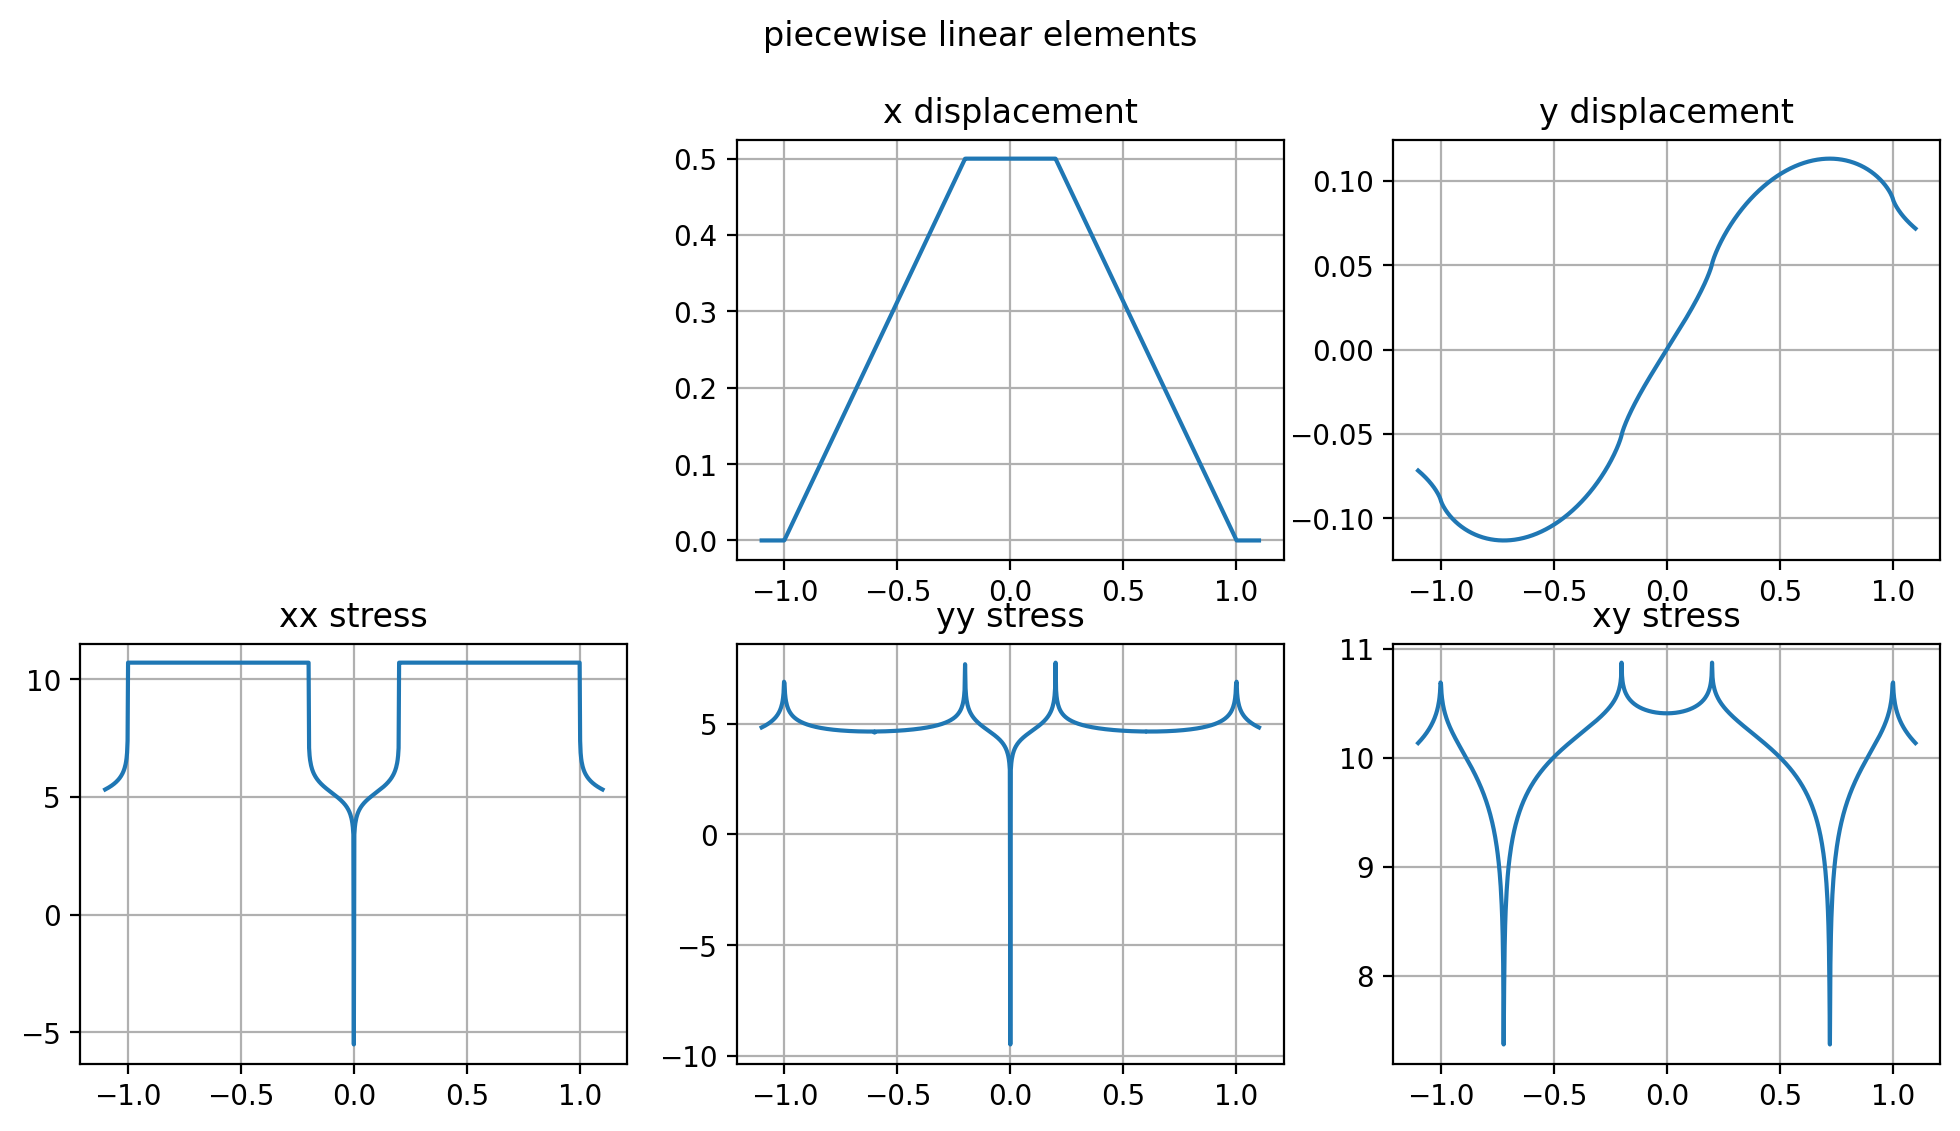

In [226]:
linear_y1 = np.array((0.,0.5,1.,1.,0.5))
linear_y2 = np.array((0.5,1.,1.,0.5,0.))

displacement_linear_total = np.zeros((2, len(x_obs)))
stress_linear_total = np.zeros((3, len(x_obs)))
# offset = np.array([0.43333333])

for i in range(len(elements)):
    print(f"{i=}")

    # Calculate quadratic weights for linear slip
    node_coordinates = elements[i]["x_integration_points"]
    node_coordinates = np.array(
        [
            elements[i]["x1"],
            0.5 * (elements[i]["x1"] + elements[i]["x2"]),
            elements[i]["x2"],
        ]
    ) - 0.5 * (elements[i]["x1"] + elements[i]["x2"])
    print(f"{node_coordinates=}")

    element_half_length = elements[i]["half_length"]
    end_displacement_1 = linear_y1[i]
    end_displacement_2 = linear_y2[i]
    print(f"{end_displacement_1=:0.3f}, {end_displacement_2=:0.3f}")

    quadratic_coefficients = LOCAL_get_quadratic_coefficients_for_linear_slip(
        element_half_length, node_coordinates, end_displacement_1, end_displacement_2
    )
    strike_slip_linear = np.copy(quadratic_coefficients)
    print(f"{strike_slip_linear=}")
    tensile_slip_linear = [0.0, 0.0, 0.0]

    # Calculate displacements and stresses for current element
    (
        displacement_linear,
        stress_linear,
    ) = bemcs.displacements_stresses_quadratic_no_rotation(
        x_obs,
        y_obs,
        elements[i]["half_length"],
        mu,
        nu,
        strike_slip_linear,
        tensile_slip_linear,
        elements[i]["x_center"],
        elements[i]["y_center"],
    )

    # Add current element contribution to total
    displacement_linear_total += displacement_linear
    stress_linear_total += stress_linear

plot_line_values(
    x_obs,
    displacement_linear_total,
    stress_linear_total,
    "piecewise linear elements",
)


# Single quadratic slip element

end_displacement_1=0.000, end_displacement_2=1.000
IN BEMCS - physical_displacements=array([0. , 0.5, 1. ])
IN BEMCS - quadratic_coefficients=array([0.16666667, 0.5       , 0.83333333])
quadratic_coefficients=array([0.16666667, 0.5       , 0.83333333])
strike_slip_linear=array([0.16666667, 0.5       , 0.83333333])


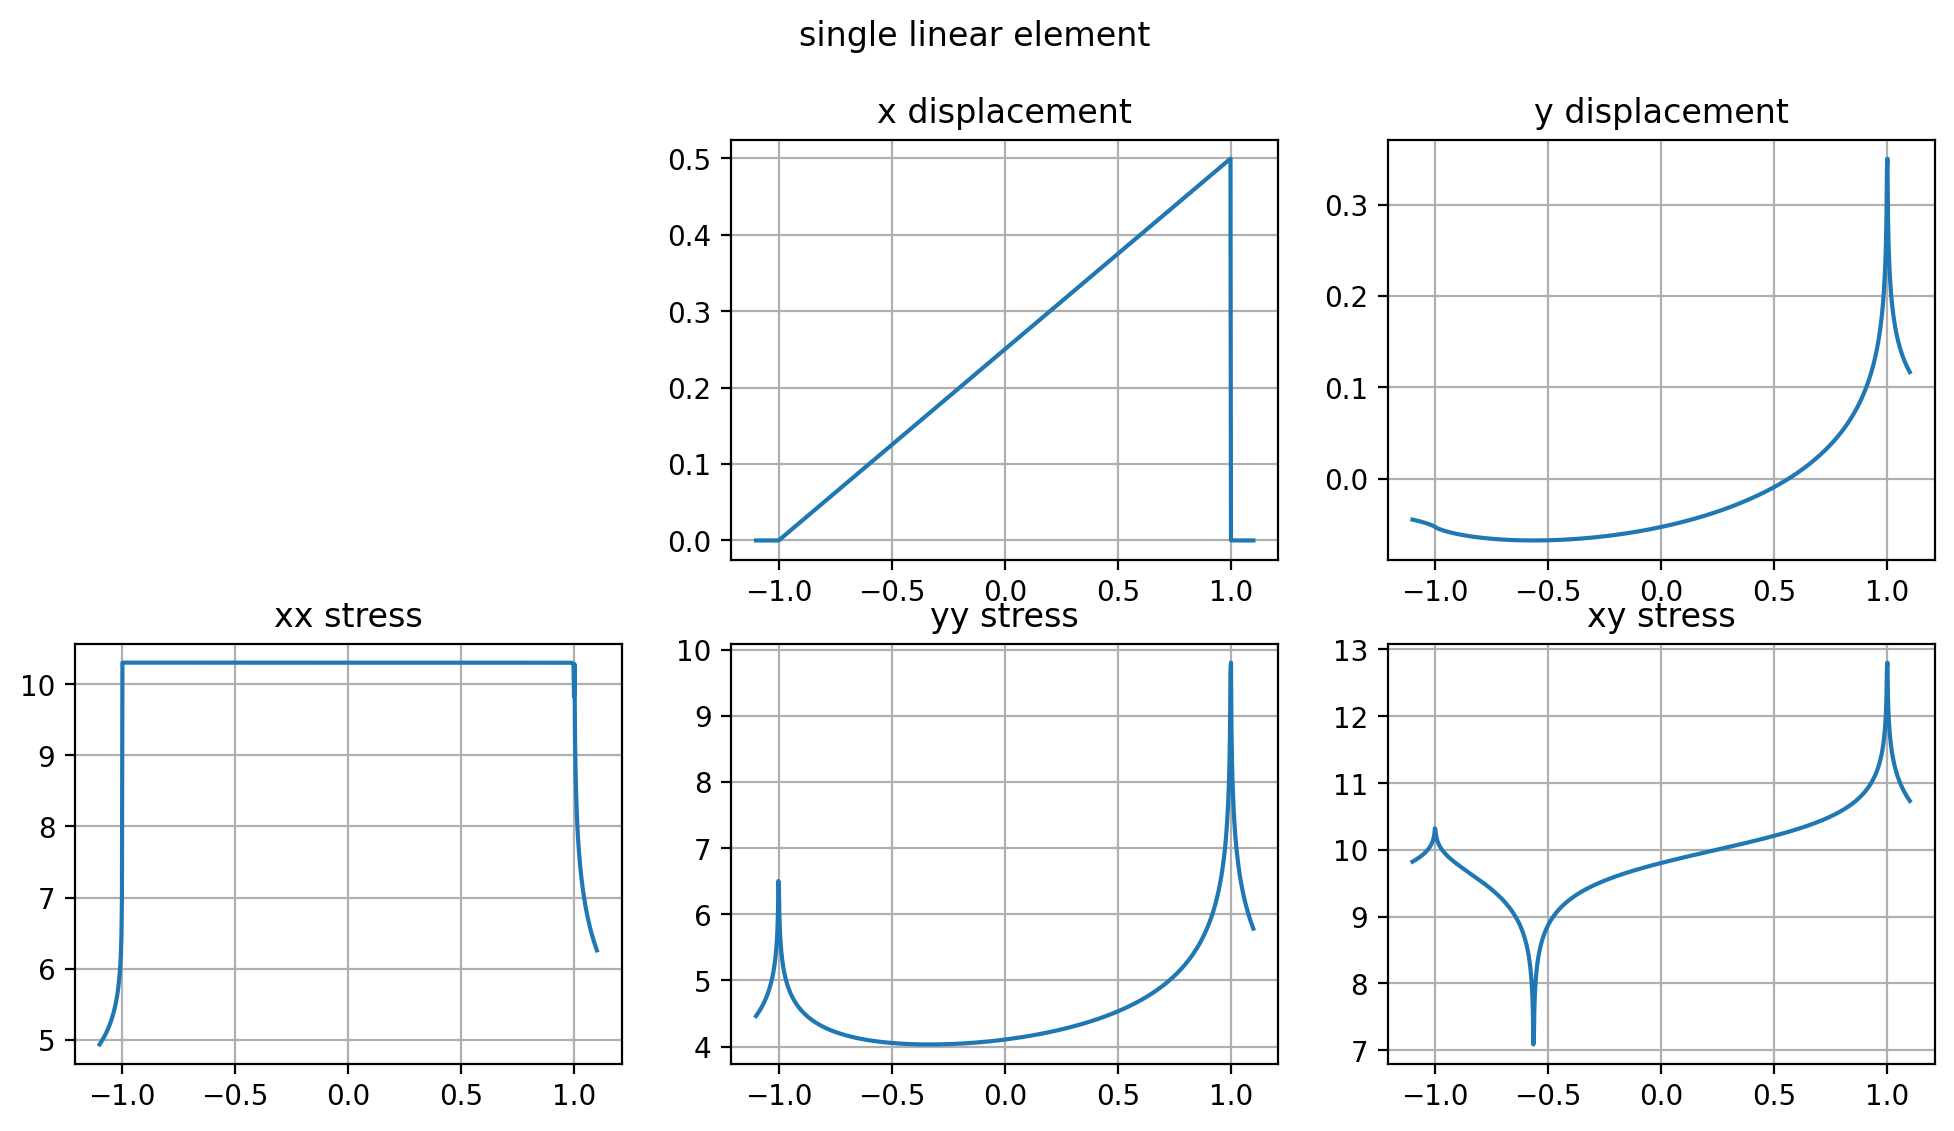

In [227]:
elements_single = []
element = {}
L = 1
x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, 1)

for i in range(0, x1.size):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements_single.append(element.copy())
elements_single = bemcs.standardize_elements(elements_single)


node_coordinates = elements_single[0]["x_integration_points"]
node_coordinates = np.array([-1.0, 0.0, 1.0])  # WAT????

element_half_length = elements_single[0]["half_length"]
end_displacement_1 = 0.0
end_displacement_2 = 1.0
print(f"{end_displacement_1=:0.3f}, {end_displacement_2=:0.3f}")

quadratic_coefficients = bemcs.get_quadratic_coefficients_for_linear_slip(
    element_half_length, node_coordinates, end_displacement_1, end_displacement_2
)

print(f"{quadratic_coefficients=}")
strike_slip_linear = np.copy(quadratic_coefficients)
print(f"{strike_slip_linear=}")
tensile_slip_linear = [0.0, 0.0, 0.0]

(
    displacement_quadratic,
    stress_quadratic,
) = bemcs.displacements_stresses_quadratic_no_rotation(
    x_obs,
    y_obs,
    elements_single[0]["half_length"],
    mu,
    nu,
    strike_slip_linear,
    tensile_slip_linear,
    elements_single[0]["x_center"],
    elements_single[0]["y_center"],
)

plot_line_values(
    x_obs,
    displacement_quadratic,
    stress_quadratic,
    "single linear element",
)


# Experiments with physical slip to quadratic weights

quadradic_weights=array([0.16666667, 0.5       , 0.83333333])


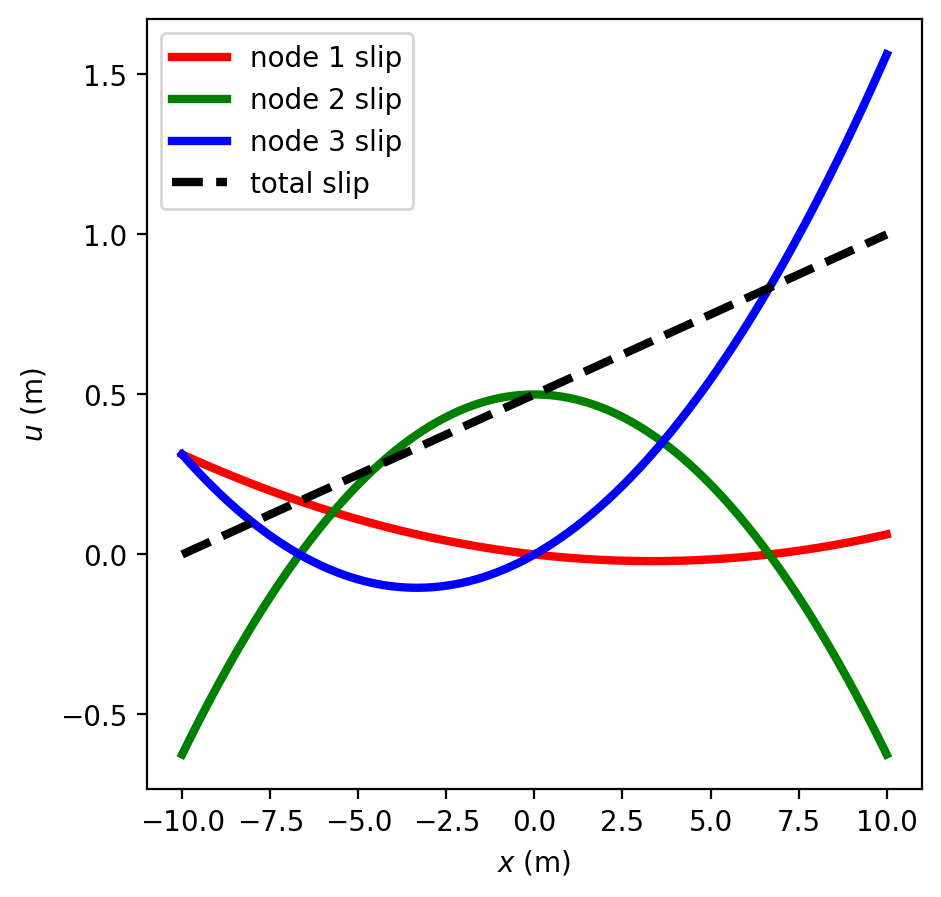

In [228]:
linewidth = 3.0
fontsize = 10

# Element half width
a = 10

# Observation coordinates on which to evaluate shape functions
n = 1000
x = np.linspace(-a, a, n)

# Quadratic shape functions
qaudratic_shape_function_1 = (x / a) * (9 * (x / a) / 8 - 3 / 4)
qaudratic_shape_function_2 = (1 - 3 * (x / a) / 2) * (1 + 3 * (x / a) / 2)
qaudratic_shape_function_3 = (x / a) * (9 * (x / a) / 8 + 3 / 4)

# Displacement at left edge, center, and right edge
physical_slip = np.array([0.0, 0.5, 1.0])  # linear slip
node_coordinates = np.array([-a, 0, a])  # not sure how to set these
quadradic_weights = LOCAL_phicoef(node_coordinates, physical_slip, a)
print(f"{quadradic_weights=}")

# Plot 3 shape functions and total slip
plt.figure(figsize=(5, 5))
plt.plot(
    x,
    quadradic_weights[0] * qaudratic_shape_function_1,
    "-r",
    linewidth=linewidth,
    label="node 1 slip",
)
plt.plot(
    x,
    quadradic_weights[1] * qaudratic_shape_function_2,
    "-g",
    linewidth=linewidth,
    label="node 2 slip",
)
plt.plot(
    x,
    quadradic_weights[2] * qaudratic_shape_function_3,
    "-b",
    linewidth=linewidth,
    label="node 3 slip",
)
plt.plot(
    x,
    quadradic_weights[0] * qaudratic_shape_function_1
    + quadradic_weights[1] * qaudratic_shape_function_2
    + quadradic_weights[2] * qaudratic_shape_function_3,
    "--k",
    linewidth=linewidth,
    label="total slip",
)
plt.legend()
plt.xlabel("$x$ (m)", fontsize=fontsize)
plt.ylabel("$u$ (m)", fontsize=fontsize)
plt.gca().tick_params(labelsize=fontsize)
plt.show()
